In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU.")
else:
    print("TensorFlow will run on CPU.")

tf.config.optimizer.set_experimental_options({
    "disable_meta_optimizer": True
})

print("#################################")

import h5py
import numpy as np
from tensorflow.keras import utils
with h5py.File('/content/drive/My Drive/Sem2/Topics_in_ML/Project/Galaxy10_DECals1.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
labels = utils.to_categorical(labels, 10)
labels = labels.astype(np.float32)
images = images.astype(np.float32)
print("Cell 1 Done")

print("#################################")

from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]
def preprocess(img):
    img = tf.image.resize(img, [64, 64])
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train_images = np.array([preprocess(img) for img in train_images])
print("Cell 2 Done")

print("#################################")

import matplotlib.pyplot as plt

def sample_batch(images, batch_size=1):
    indices = np.random.choice(images.shape[0], batch_size, replace=False)
    return images[indices]
def display(images, n=10, size=(20, 20), cmap=None, as_type=None, save_to=None):
    plt.figure(figsize=size)
    for i in range(min(n, images.shape[0])):
        plt.subplot(1, n, i + 1)
        img = images[i]
        if as_type:
            img = img.astype(as_type)
        if img.max() > 1.0:
            img = img / 255.0
        plt.imshow(img, cmap=cmap)
        plt.axis("off")
    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")
    plt.show()
print("Cell 3 done")

print("#################################")

train_sample = sample_batch(train_images)
from keras import (layers, models, callbacks, losses, utils, metrics, optimizers)
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 64
Z_DIM = 100
EPOCHS = 200
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0001
NOISE_PARAM = 0.5
print("Cell 4 done")

print("#################################")

discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=1, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1024, kernel_size=4, strides=1, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)
discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

print("#################################")

# generator_input = layers.Input(shape=(Z_DIM,))
# #x = layers.Reshape((1, 1, Z_DIM))(generator_input)
# x = layers.Dense(2*2*1024, use_bias=False)(generator_input)
# x = layers.Reshape((2, 2, 1024))(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(0.2)(x)

# x = layers.Conv2DTranspose(
#     1024, kernel_size=4, strides=1, padding="same", use_bias=False
# )(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Conv2DTranspose(
#     512, kernel_size=4, strides=1, padding="same", use_bias=False
# )(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Conv2DTranspose(
#     256, kernel_size=4, strides=1, padding="same", use_bias=False
# )(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Conv2DTranspose(
#     128, kernel_size=4, strides=1, padding="same", use_bias=False
# )(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Conv2DTranspose(
#     64, kernel_size=4, strides=1, padding="same", use_bias=False
# )(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# generator_output = layers.Conv2DTranspose(
#     CHANNELS,
#     kernel_size=4,
#     strides=1,
#     padding="same",
#     use_bias=False,
#     activation="tanh",
# )(x)
# generator = models.Model(generator_input, generator_output)
# generator.summary()

generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Dense(2*2*1024, use_bias=False)(generator_input)  # Start from a 2x2 feature map
x = layers.Reshape((2, 2, 1024))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

# Increasing strides to upscale the feature map
x = layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same", use_bias=False)(x)  # 4x4
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)  # 8x8
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)  # 16x16
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)  # 32x32
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)  # 64x64
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=1, padding="same", use_bias=False, activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

print("#################################")

class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}
print("Cell 5 Done")

print("#################################")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
        )
print("Cell 6 Done")

print("#################################")

dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)
if LOAD_MODEL:
    dcgan.load_weights("/content/drive/My Drive/Sem2/Topics_in_ML/Project/checkpoint/checkpoint.ckpt")

dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)
print("Running model.fit")

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/Sem2/Topics_in_ML/Project/checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="logs")
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            #save_to="/content/drive/My Drive/Sem2/Topics_in_ML/Project/output/Day3/generated_img_%03d.png" % (epoch),
        )

dcgan.fit(
    train_images,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        #ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)
print("Cell 7 Done")

print("#################################")

print("Saving models")
generator.save("/content/drive/My Drive/Sem2/Topics_in_ML/Project/models/generator")
discriminator.save("/content/drive/My Drive/Sem2/Topics_in_ML/Project/models/discriminator")

print("All tasks completed successfully!")
print("#################################")

Num GPUs Available:  1
TensorFlow will run on GPU.
#################################


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/My Drive/Sem2/Topics_in_ML/Project/Galaxy10_DECals1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 11ms/step


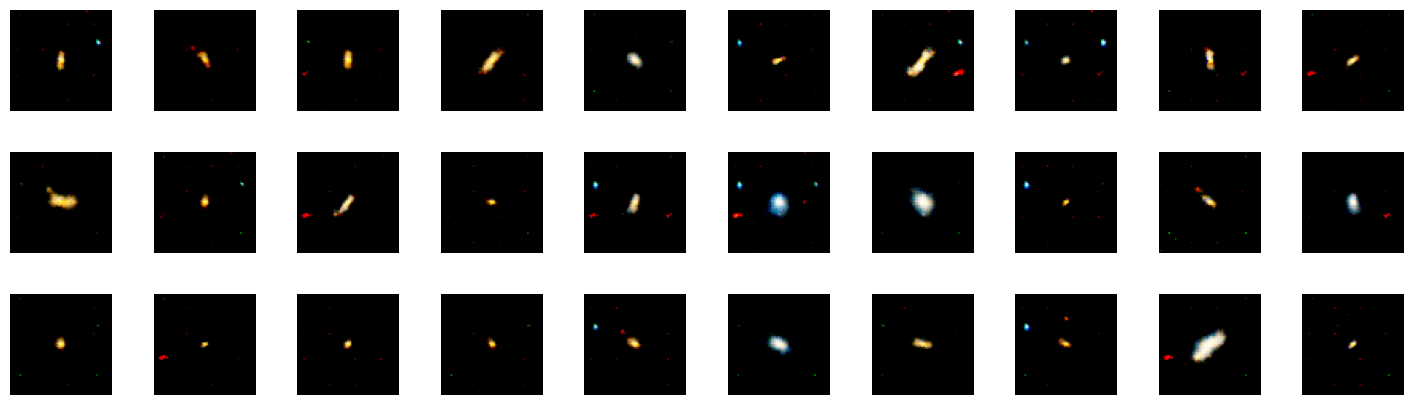

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train_images.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

AttributeError: 'numpy.ndarray' object has no attribute 'as_numpy_iterator'

1/1 [==============================] - 0s 11ms/step


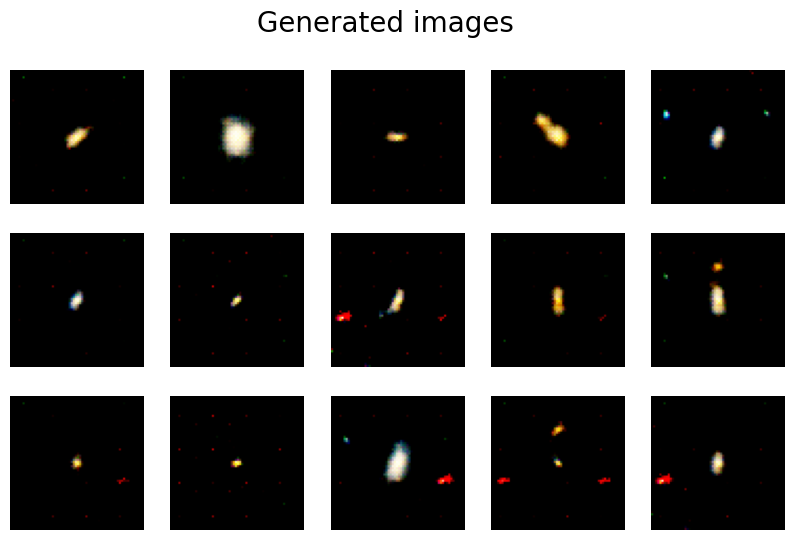

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

NameError: name 'r' is not defined

In [ ]:
pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Sem2/Topics_in_ML/Project/"

checkpoint  Galaxy10_DECals1.h5  Galaxy10_DECals.h5  logs  models  output  Project_Report.gdoc
